### **Regression by Prophet**
make uncertainty prediction by Prophet regression

In [106]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 100000
from tqdm import tqdm

from myConfig import *
import gc
from myUtils import *
from myProphet import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
data_path = os.path.join("mydata","agg_train_eval.pickle")
data = pd.read_pickle(data_path)

cols = [c for c in data.columns if "d_" in c]
data = data[cols]
data = data.T
data.index.name = "d"
data = data.reset_index()

print("**** aggregated train_data ****")
data

**** aggregated train_data ****


,d,Total_X,CA_X,TX_X,WI_X,CA_1_X,CA_2_X,CA_3_X,CA_4_X,TX_1_X,...,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516_CA_2,HOUSEHOLD_2_516_CA_3,HOUSEHOLD_2_516_CA_4,HOUSEHOLD_2_516_TX_1,HOUSEHOLD_2_516_TX_2,HOUSEHOLD_2_516_TX_3,HOUSEHOLD_2_516_WI_1,HOUSEHOLD_2_516_WI_2,HOUSEHOLD_2_516_WI_3
0,d_1,32631,14195,9438,8998,4337,3494,4739,1625,2556,...,0,0,0,0,0,0,2,0,0,0
1,d_2,31749,13805,9630,8314,4155,3046,4827,1777,2687,...,1,0,1,0,0,1,0,0,0,1
2,d_3,23783,10108,6778,6897,2816,2121,3785,1386,1822,...,0,0,0,0,0,0,0,0,0,0
3,d_4,25412,11047,7381,6984,3051,2324,4232,1440,2258,...,0,0,1,0,0,0,0,1,0,1
4,d_5,19146,9925,5912,3309,2630,1942,3817,1536,1694,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,d_1937,37096,15678,10375,11043,3995,3789,5375,2519,3147,...,0,1,0,0,0,0,0,0,0,0
1937,d_1938,36963,16297,9162,11504,4136,4037,5580,2544,2748,...,0,1,0,0,0,0,0,0,0,0
1938,d_1939,42552,17430,12303,12819,4433,4751,5542,2704,3664,...,1,0,0,0,0,0,1,1,0,0
1939,d_1940,51518,23103,13681,14734,5764,7120,7073,3146,4167,...,0,3,0,0,0,0,1,0,0,0


#### **最強Notebookの点推定, 合算値**

In [87]:
best_ppred = pd.read_csv(os.path.join("submission_point","M5-Forecasting-EDA_FE_and_Modeling_submission.csv"))
best_ppred.columns = ["id"] + ["d_"+str(i) for i in range(1914,1914+28)]
best_ppred = best_ppred.set_index("id",drop=True)

sales_train_val = pd.read_csv(os.path.join("rawdata","sales_train_validation.csv"))

best_ppred = best_ppred.loc[sales_train_val["id"]].reset_index()

best_ppred = pd.merge(best_ppred,sales_train_val[["id","item_id","dept_id","cat_id","store_id","state_id"]],on=["id"],how="left")
best_ppred = get_agg_df(best_ppred)

cols = [c for c in best_ppred.columns if "d_" in c]
best_ppred = best_ppred[cols]
best_ppred = best_ppred.T
best_ppred.index.name = "d"
best_ppred = best_ppred.reset_index()

best_ppred.head(5)

,d,Total_X,CA_X,TX_X,WI_X,CA_1_X,CA_2_X,CA_3_X,CA_4_X,TX_1_X,...,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516_CA_2,HOUSEHOLD_2_516_CA_3,HOUSEHOLD_2_516_CA_4,HOUSEHOLD_2_516_TX_1,HOUSEHOLD_2_516_TX_2,HOUSEHOLD_2_516_TX_3,HOUSEHOLD_2_516_WI_1,HOUSEHOLD_2_516_WI_2,HOUSEHOLD_2_516_WI_3
0,d_1914,38793.0,17524.0,10662.0,10607.0,4472.0,3926.0,6359.0,2767.0,3076.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,d_1915,35487.0,15012.0,9933.0,10542.0,3703.0,3525.0,5289.0,2495.0,2853.0,...,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,d_1916,34445.0,14836.0,9575.0,10034.0,3715.0,3527.0,5065.0,2529.0,2984.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,d_1917,34732.0,14664.0,9655.0,10413.0,3618.0,3754.0,5015.0,2277.0,2664.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,d_1918,42896.0,17180.0,12162.0,13554.0,4573.0,4382.0,5705.0,2520.0,3687.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### **日にち情報付与**

In [88]:
calendar = pd.read_csv(os.path.join("rawdata","calendar.csv"),parse_dates=[0])
print("**** calendar ****")
display(calendar.head(5))
print()

data = pd.merge(data,calendar[["d","date"]],on="d",how="left")
data = data.set_index("date",drop=True)
data = data.drop(columns={"d"})
print("**** data ****")
display(data.head(5))


best_ppred = pd.merge(best_ppred,calendar[["d","date"]],on="d",how="left")
best_ppred = best_ppred.set_index("date",drop=True)
best_ppred = best_ppred.drop(columns={"d"})
print("**** best ppred ****")
display(best_ppred.head(5))

**** calendar ****


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1



**** data ****


,Total_X,CA_X,TX_X,WI_X,CA_1_X,CA_2_X,CA_3_X,CA_4_X,TX_1_X,TX_2_X,...,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516_CA_2,HOUSEHOLD_2_516_CA_3,HOUSEHOLD_2_516_CA_4,HOUSEHOLD_2_516_TX_1,HOUSEHOLD_2_516_TX_2,HOUSEHOLD_2_516_TX_3,HOUSEHOLD_2_516_WI_1,HOUSEHOLD_2_516_WI_2,HOUSEHOLD_2_516_WI_3
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,32631,14195,9438,8998,4337,3494,4739,1625,2556,3852,...,0,0,0,0,0,0,2,0,0,0
2011-01-30,31749,13805,9630,8314,4155,3046,4827,1777,2687,3937,...,1,0,1,0,0,1,0,0,0,1
2011-01-31,23783,10108,6778,6897,2816,2121,3785,1386,1822,2731,...,0,0,0,0,0,0,0,0,0,0
2011-02-01,25412,11047,7381,6984,3051,2324,4232,1440,2258,2954,...,0,0,1,0,0,0,0,1,0,1
2011-02-02,19146,9925,5912,3309,2630,1942,3817,1536,1694,2492,...,1,0,0,0,0,0,0,0,0,0


**** best ppred ****


,Total_X,CA_X,TX_X,WI_X,CA_1_X,CA_2_X,CA_3_X,CA_4_X,TX_1_X,TX_2_X,...,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516_CA_2,HOUSEHOLD_2_516_CA_3,HOUSEHOLD_2_516_CA_4,HOUSEHOLD_2_516_TX_1,HOUSEHOLD_2_516_TX_2,HOUSEHOLD_2_516_TX_3,HOUSEHOLD_2_516_WI_1,HOUSEHOLD_2_516_WI_2,HOUSEHOLD_2_516_WI_3
date,,,,,,,,,,,,,,,,,,,,,
2016-04-25,38793.0,17524.0,10662.0,10607.0,4472.0,3926.0,6359.0,2767.0,3076.0,3883.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2016-04-26,35487.0,15012.0,9933.0,10542.0,3703.0,3525.0,5289.0,2495.0,2853.0,3502.0,...,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-27,34445.0,14836.0,9575.0,10034.0,3715.0,3527.0,5065.0,2529.0,2984.0,3256.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-04-28,34732.0,14664.0,9655.0,10413.0,3618.0,3754.0,5015.0,2277.0,2664.0,3441.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2016-04-29,42896.0,17180.0,12162.0,13554.0,4573.0,4382.0,5705.0,2520.0,3687.0,4023.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### **Prophet Regression**
https://facebook.github.io/prophet/docs/quick_start.html

In [89]:
# Forecast days
import datetime as dt
start = dt.datetime(2016,4,25)
end = start + dt.timedelta(days=27)

print("Forecast ",start,"<->",end)

Forecast  2016-04-25 00:00:00 <-> 2016-05-22 00:00:00


#### **Prophetの回帰テスト, 可視化**

Time Series: Total_X


C:\Users\organ\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


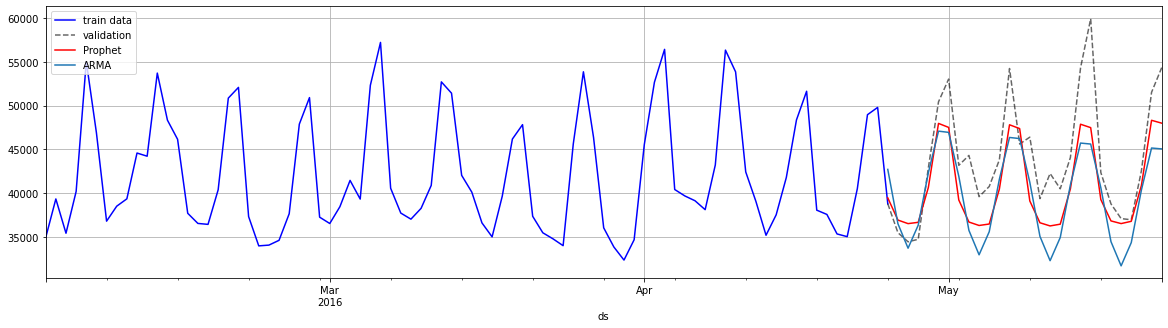

Time Series: CA_X


C:\Users\organ\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


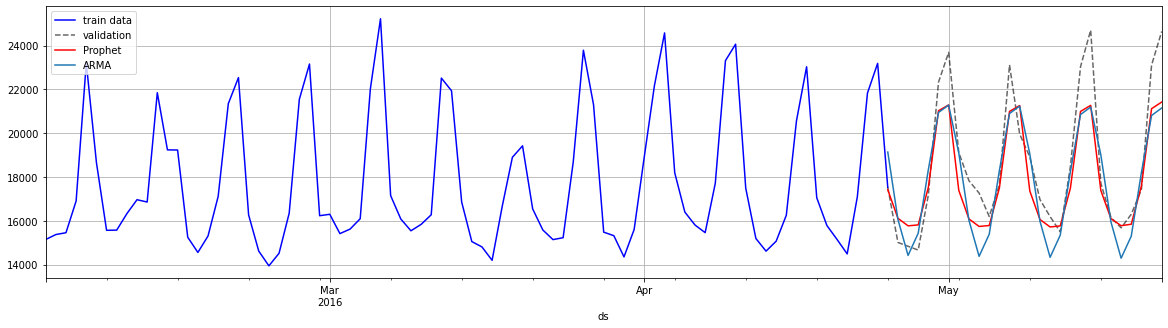

In [111]:
import statsmodels.api as sm
for col in data.columns[:2]:
    
    print("Time Series:",col)
    ts = data[col]
    
    model = myProphet()
    model.fit(y=ts[ts.index < start])
    pred = model.predict(start=start,end=end,freq="1D",mode="all")
    arma_pred = sm.tsa.ARMA(ts[ts.index < start], (3, 3)).fit().predict(start=start,end=end)
    
    # prophet使うときはこれがいる
    pd.plotting.register_matplotlib_converters()
    
    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(1,1,1)
    #ax.set_title(col,fontsize=15)
    
    ts[data.index <= start][-28*3:].plot(style="b-",label="train data",ax=ax)
    ts[start <= ts.index].plot(style="k--",label="validation",ax=ax,alpha=0.6)
    
    # beste prediction 
    #best_ppred[start <= best_ppred.index][col].plot(style="g-",label="best score NB",ax=ax)
    
    # prophet prediction
    pred["yhat"].plot(style="r-",label="Prophet",ax=ax)
    #ax.fill_between(x=pred.index,
    #                y1=pred["yhat_upper"].values,
    #                y2=pred["yhat_lower"].values,
    #                color="red",
    #                alpha=0.3,label="80% uncertainty")
    
    # ARMA
    arma_pred.plot(label="ARMA",ax=ax)
    
    ax.legend()
    ax.grid(True)
    
    plt.show()

In [3]:
%%time
import xgboost as xgb
import time
import pandas as pd
import numpy as np

time_list = []
for N in 10**np.array(range(8)):
#N = 50000000
    start = time.time()
    d = 28
    trainX = pd.DataFrame(columns=["F_"+str(i) for i in range(d)],
                         data = np.random.random((N,d)))
    trainY = pd.Series(data=np.random.random(N))
    print(trainX.shape)

    # set config
    params = {
        'objective': "reg:squarederror",
        'eval_metric': 'rmse',
        'tree_method':'gpu_hist',
    }

    # train models
    #r"""
    print("start training")
    model = xgb.train(params,
                      xgb.DMatrix(trainX,trainY),
                      num_boost_round=100)
    print("complete")
    
    time_list.append(time.time() - start)

(1, 28)
start training
complete
(10, 28)
start training
complete
(100, 28)
start training
complete
(1000, 28)
start training
complete
(10000, 28)
start training
complete
(100000, 28)
start training
complete
(1000000, 28)
start training
complete
(10000000, 28)
start training
complete
Wall time: 23.5 s


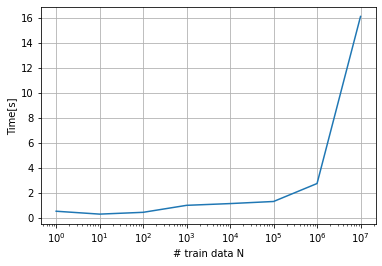

In [9]:
import matplotlib.pyplot as plt

plt.plot(10**np.array(range(8)),time_list)
plt.ylabel("Time[s]")
plt.xlabel("# train data N")
plt.xscale("log")
plt.grid(True)
plt.show()